In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from dataset_utils import generate_train_mixture, generate_competition_eval_mixture
from dataset_utils import SigSepDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

2024-04-04 10:47:05.164352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 10:47:05.164403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 10:47:05.165340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 10:47:05.171104: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 10:47:07.455931: I tensorflow/core/common_

In [3]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels,
                 out_channels, kernel_size, dilation, bias=True):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=self.padding, dilation=dilation, bias=bias)

    def forward(self, x):
        x = self.conv(x)
        if self.padding != 0:
            x = x[:, :, :-self.padding]
        return x


class ResidualBlock(nn.Module):
    def __init__(self, residual_channels, dilation):
        super(ResidualBlock, self).__init__()
        # TODO: replace with learnable dilation and padding 1D convolution
        self.dilated_conv = nn.Conv1d(
            residual_channels, 2 * residual_channels, 3, padding=dilation, dilation=dilation)
        self.conv1x1 = nn.Conv1d(residual_channels, 2 * residual_channels, 1)
        self.norm = nn.BatchNorm1d(residual_channels)

    def forward(self, x):
        residual = x
        x = self.dilated_conv(x)

        gate, filter = torch.chunk(x, 2, dim=1)
        x = torch.sigmoid(gate) * torch.tanh(filter)

        x = self.conv1x1(x)
        x, skip = torch.chunk(x, 2, dim=1)

        return self.norm(x + residual), skip


class WaveNet(nn.Module):
    def __init__(self, input_channels=2,
                 residual_channels=512,
                 residual_layers=30, dilation_cycle_length=10):
        super(WaveNet, self).__init__()
        self.input_projection = CausalConv1d(
            input_channels, residual_channels, 1, 1)

        self.residual_layers = nn.ModuleList([
            ResidualBlock(residual_channels, 2**(i % dilation_cycle_length))
            for i in range(residual_layers)
        ])

        self.skip_projection = nn.Conv1d(
            residual_channels, residual_channels, 1)
        self.output_projection = nn.Conv1d(
            residual_channels, input_channels, 1)

    def forward(self, x):
        x = self.input_projection(x)
        skip = None
        for layer in self.residual_layers:
            x, s = layer(x)
            skip = s if skip is None else skip + s

        # normalize with sqrt(num_residual_layers)
        x = skip / sqrt(len(self.residual_layers))
        x = F.relu(skip)
        x = self.skip_projection(x)
        x = F.relu(x)
        x = self.output_projection(x)
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"Using device: {}".format(device)

'Using device: cuda'

In [5]:
# load the training and validation datasets

batch_size = 4
num_batches = 50
soi_type = "QPSK"

# dataset_path, _, _ = generate_train_mixture(
#     batch_size=batch_size, num_batches=num_batches, soi_type=soi_type,
#     intrf_path_dir="rf_datasets/train_test_set_unmixed/dataset/interferenceset_frame")

In [6]:
# dataset = SigSepDataset(dataset_path, dtype="real")
dataset = SigSepDataset(
    "rf_datasets/train_set_mixed/datasets/QPSK_20240404_094911", dtype="real")
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

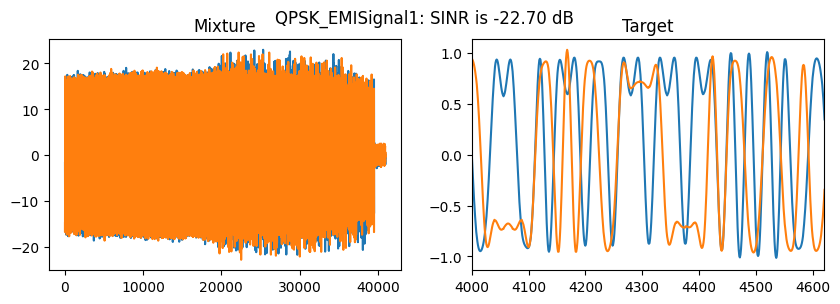

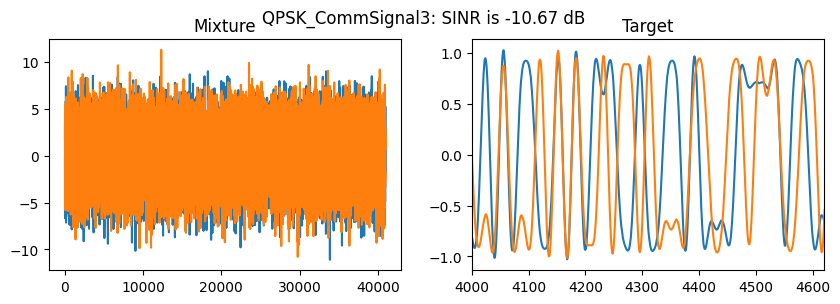

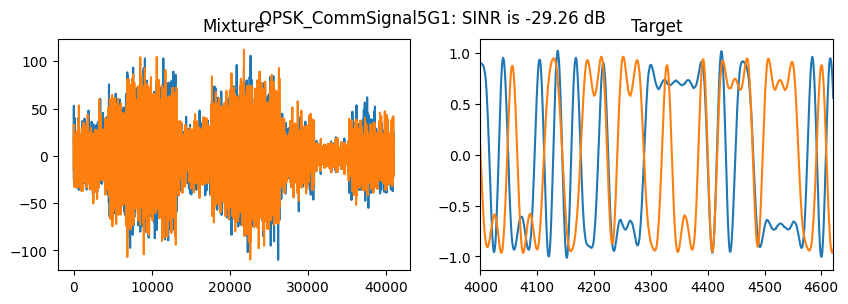

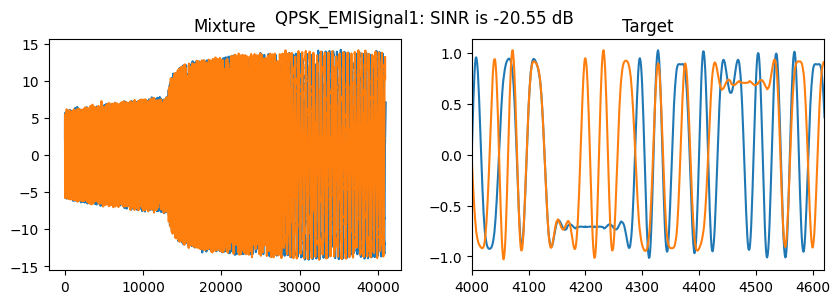

In [7]:
intrf_signal_set = ["CommSignal2",
                    "CommSignal3", "CommSignal5G1", "EMISignal1"]
for (soi_mix, soi_target, msg_bits, intrf_type, sinr) in train_loader:
    for i in range(batch_size):
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        axes[0].plot(soi_mix[i, :, :].numpy().T)
        axes[0].set_title("Mixture")
        axes[1].plot(soi_target[i, :, :].numpy().T)
        axes[1].set_title("Target")
        fig.suptitle("{}_{}: SINR is {:.2f} dB".format(
            soi_type, intrf_signal_set[intrf_type[i].item()], sinr[i].item()))
        plt.xlim([4000, 4620])
        plt.show()
    break

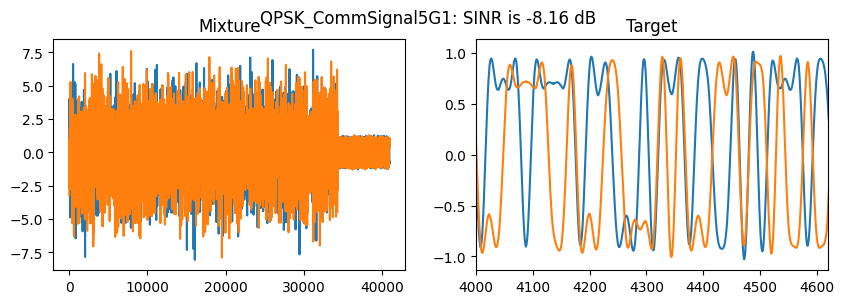

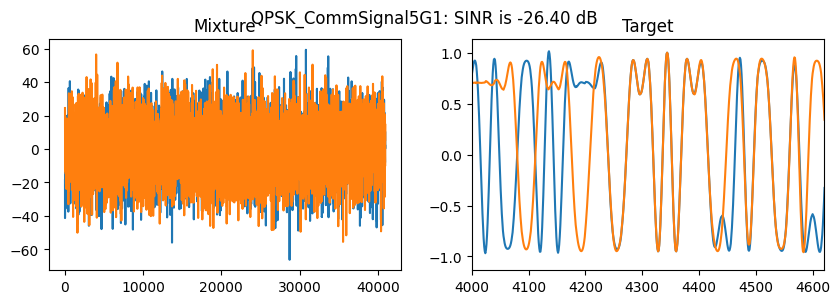

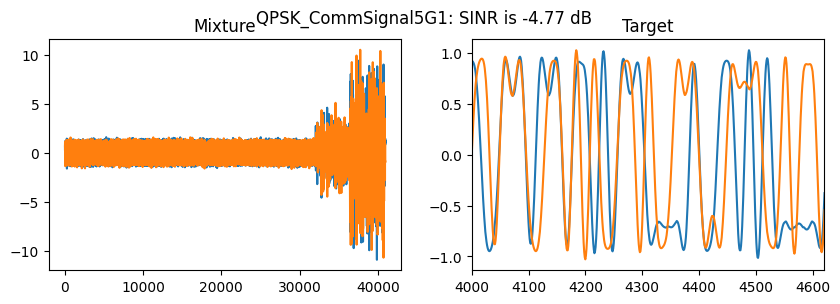

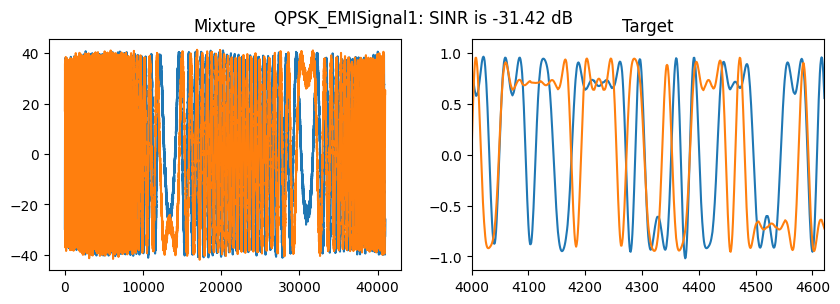

In [8]:
for (soi_mix, soi_target, msg_bits, intrf_type, sinr) in val_loader:
    for i in range(batch_size):
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        axes[0].plot(soi_mix[i, :, :].numpy().T)
        axes[0].set_title("Mixture")
        axes[1].plot(soi_target[i, :, :].numpy().T)
        axes[1].set_title("Target")
        fig.suptitle("{}_{}: SINR is {:.2f} dB".format(
            soi_type, intrf_signal_set[intrf_type[i].item()], sinr[i].item()))
        plt.xlim([4000, 4620])
        plt.show()
    break

In [9]:
model_params = {
    "input_channels": 2,
    "residual_channels": 512,
    "residual_layers": 20,
    "dilation_cycle_length": 10
}

model = WaveNet(**model_params).to(device)
"The model has {} million parameters".format(
    sum(p.numel() for p in model.parameters()) / 1e6)

'The model has 42.269698 million parameters'

In [10]:
EPOCHS = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()
criterion = nn.MSELoss()

In [ ]:
history = {
    "train_loss": [],
    "val_loss": []
}


top_k_checkpoints = 3
best_val_losses = [float("inf")] * top_k_checkpoints
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

for epoch in range(EPOCHS):
    print("Epoch: {}".format(epoch))
    model.train()
    avg_tloss = 0.0
    for i, (soi_mix, soi_target, _, _, _) in enumerate(train_loader):
        soi_mix, soi_target = soi_mix.to(device), soi_target.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            soi_est = model(soi_mix)
            loss = criterion(soi_est, soi_target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        avg_tloss += loss.item()

    avg_tloss /= len(train_loader)
    print("\ttrain loss: {:.4f}".format(epoch, avg_tloss))
    history["train_loss"].append(avg_tloss)

    model.eval()
    avg_vloss = 0.0
    for i, (soi_mix, soi_target, _, _, _) in enumerate(val_loader):
        soi_mix, soi_target = soi_mix.to(device), soi_target.to(device)
        with torch.no_grad():
            soi_est = model(soi_mix)
            loss = criterion(soi_est, soi_target)
        avg_vloss += loss.item()
    avg_vloss /= len(val_loader)
    print("\tval loss: {:.4f}".format(epoch, avg_vloss))
    history["val_loss"].append(avg_vloss)

    # After updating avg_vloss and before saving the model
    if avg_vloss < max(best_val_losses):
        # Replace the max loss in best_val_losses with the current avg_vloss
        max_best_val_loss = max(best_val_losses)
        max_loss_index = best_val_losses.index(max_best_val_loss)
        best_val_losses[max_loss_index] = avg_vloss
        # Save model as before
        model_path = f"checkpoints/KUTII_WaveNet-epoch_{epoch+1}_vloss_{avg_vloss}.pt"
        model_checkpoint = {
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": avg_vloss
        }
        torch.save(model_checkpoint, model_path)
        print(f"Model saved to {model_path}")
        # delete replaced checkpoint
        for file in os.listdir("models"):
            if file.endswith(f"vloss_{max_best_val_loss}.pt"):
                os.remove(f"models/{file}")

In [ ]:
# load save checkpoint
model.load_state_dict(torch.load(model_path)["state_dict"])

In [ ]:
test_datset_path = generate_competition_eval_mixture(soi_type=soi_type,
                                                     intrf_path_dir="rf_datasets/train_test_set_unmixed/dataset/testset1_frame")
test_dataset = SigSepDataset(test_datset_path, dtype="real")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model.eval()

results = {
    key: {
        "sinr_all": [],
        "soi_target_all": [],
        "soi_est_all": [],
        "msg_bits_all": [],
        "soi_no_mitigation_all": [],
    } for key in intrf_signal_set
}


for i, (soi_mix, soi_target, msg_bits, intrf_type, sinr) in enumerate(test_loader):
    soi_mix = soi_mix.to(device)
    with torch.no_grad():
        soi_est = model(soi_mix)
    results[intrf_signal_set[intrf_type.item()]]["sinr_all"].extend(sinr.item())
    results[intrf_signal_set[intrf_type.item()]]["soi_target_all"].extend(
        soi_target.numpy())
    results[intrf_signal_set[intrf_type.item()]]["soi_est_all"].extend(
        soi_est.cpu().numpy())
    results[intrf_signal_set[intrf_type.item()]]["msg_bits_all"].extend(
        msg_bits.numpy())
    results[intrf_signal_set[intrf_type.item()]]["soi_no_mitigation_all"].extend(
        soi_mix.cpu().numpy())

for intrf_type in intrf_signal_set:
    results[intrf_type]["sinr_all"] = np.array(results[intrf_type]["sinr_all"])
    results[intrf_type]["soi_target_all"] = np.array(
        results[intrf_type]["soi_target_all"])
    results[intrf_type]["soi_est_all"] = np.array(
        results[intrf_type]["soi_est_all"])
    results[intrf_type]["msg_bits_all"] = np.array(
        results[intrf_type]["msg_bits_all"])
    results[intrf_type]["soi_no_mitigation_all"] = np.array(
        results[intrf_type]["soi_no_mitigation_all"])

In [ ]:
results, results["CommSignal2"]["soi_target_all"].shape

In [ ]:
# post processing and evaluation
# combine IQ channels
for intrf_type in intrf_signal_set:
    results[intrf_type]["soi_target_all"] = results[intrf_type]["soi_target_all"][:, 0, :] + \
        1j * results[intrf_type]["soi_target_all"][:, 1, :]
    results[intrf_type]["soi_est_all"] = results[intrf_type]["soi_est_all"][:, 0, :] + \
        1j * results[intrf_type]["soi_est_all"][:, 1, :]
    results[intrf_type]["soi_no_mitigation_all"] = results[intrf_type]["soi_no_mitigation_all"][:, 0, :] + \
        1j * results[intrf_type]["soi_no_mitigation_all"][:, 1, :]

In [ ]:
# evaluate the mse and ber